Bulk objects inspection

In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [1]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    # plt.grid(alpha=0.5, lw=0.5)
    return ax

def binned_stats(x, y, bins):
    from scipy import stats
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_median, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='median', bins=bins)
    bin_spread, _, _ = stats.binned_statistic(x, y, statistic=nmad, bins=bins)    
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_median, bin_spread

In [5]:
gaia_fn = 'gaia1_10_17.fits.gz'
gaia = Table.read('/Users/rongpu/Downloads/gaia_star_cutouts/'+gaia_fn)

In [6]:
# Remove duplicates
gaia.sort('SOURCE_ID')
mask = gaia['SOURCE_ID'][1:]==gaia['SOURCE_ID'][:-1]
mask = np.concatenate([[False], mask])
gaia = gaia[~mask]

In [7]:
print(len(gaia))
print(len(np.unique(gaia['SOURCE_ID'])))

4955
4955


In [8]:
gaia[:3]

SOURCE_ID,RA,RA_ERROR,DEC,DEC_ERROR,PARALLAX,PARALLAX_ERROR,PMRA,PMRA_ERROR,PMDEC,PMDEC_ERROR,ASTROMETRIC_EXCESS_NOISE,PHOT_G_MEAN_MAG,BP_RP,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,PHOT_VARIABLE_FLAG,TEFF_VAL,A_G_VAL
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,bytes13,float32,float32
72452632245539072,32.994211463771364,0.03630486797562427,11.030122911061108,0.025723471904464956,3.530114645035611,0.03680955299615472,46.8384882794626,0.0685664287669723,-50.51310640234493,0.05707370735257283,0.0,10.189775,1.2733269,-22.285404896059422,0.2956830145800138,NOT_AVAILABLE,4688.23,nan
73218579533216256,32.363729317539004,0.032103933072222306,11.394445937108227,0.026336738217227245,1.6815989355122665,0.03591921415844464,0.988633141188997,0.06425581669395072,-6.513616260898633,0.054250431635452075,0.0,13.862895,1.1229277,nan,nan,NOT_AVAILABLE,4994.0,0.7545
73271253012097280,32.131614339717856,0.032818924492033115,11.528817545893132,0.026076216830839098,0.8220777067248136,0.034087333210366264,14.218102294291352,0.0666826206643307,-6.31515803277314,0.05713864812798587,0.0,11.233503,1.4407673,27.867051573712914,0.264006630420258,NOT_AVAILABLE,4470.3867,0.4787


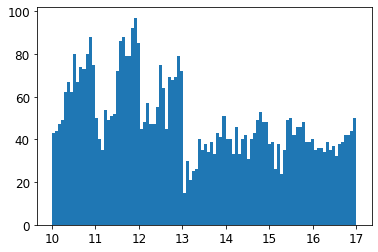

In [9]:
plt.hist(gaia['PHOT_G_MEAN_MAG'], 100);

------
## Narrow bin of GAIA-G magnitude

In [10]:
band = 'g'
# img_type = '-resid'
img_type = ''
pixscale_str = '0.262'
pixscale = float(pixscale_str)
    
idx = np.where((gaia['PHOT_G_MEAN_MAG']>12.0) & (gaia['PHOT_G_MEAN_MAG']<12.05))[0]
print(len(idx))

plot_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/plots/3'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

28


In [13]:
for index in idx:

    print('PHOT_G_MEAN_MAG = ', gaia['PHOT_G_MEAN_MAG'][index])

    ra, dec = gaia['RA'][index], gaia['DEC'][index]

    download_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/'
    file_path = os.path.join(download_dir, gaia_fn[:-8], 'gaia_{}_{}{}_{}.fits'.format(index, band, img_type, pixscale_str))

    if not os.path.isfile(file_path):
        url = 'http://legacysurvey.org/viewer/cutout.fits?ra={:f}&dec={:f}&layer=dr8{}&pixscale={}&bands={}'.format(ra, dec, img_type, pixscale_str, band)
        cmd = 'wget -O '+file_path+' \"'+url+'\"'
        print(cmd)
        os.system(cmd)

    img_raw = fitsio.read(file_path)
    img = img_raw / (pixscale**2)

    vrange = 0.5
    ax = plot_cutout(img, pixscale, vmin=-vrange, vmax=vrange)
    ax.set_title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['PHOT_G_MEAN_MAG'][index]))
    plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_image.png'))
    plt.close()

    grid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius = np.sqrt(xx**2 + yy**2).flatten()

    # Remove masked pixels
    mask = img.flatten()!=0
    radius = radius[mask]
    flux = img.flatten()[mask]

    bin_center, _, bin_median, bin_spread = binned_stats(radius, flux, bins=np.linspace(0., 31., 63))

    plt.figure(figsize=(8, 6))
    plt.plot(radius, flux, '.', ms=0.5)
    plt.plot(bin_center, bin_median, c='C1')
    plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, alpha=0.6, c='C1')
    plt.axis([0, 20, -1, 5])
    plt.axhline(0, lw=1, color='r')
    plt.grid(alpha=0.5)
    plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['PHOT_G_MEAN_MAG'][index]))
    plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile.png'))
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.loglog(radius, flux, '.', ms=0.5)
    plt.plot(bin_center, bin_median, c='C1')
    plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, alpha=0.6, c='C1')
    plt.axis([.5, 30, .02, 200])
    plt.grid(alpha=0.5)
    plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['PHOT_G_MEAN_MAG'][index]))
    plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile_log.png'))
    plt.close()

PHOT_G_MEAN_MAG =  12.018256
PHOT_G_MEAN_MAG =  12.036963
PHOT_G_MEAN_MAG =  12.01998
PHOT_G_MEAN_MAG =  12.041059
PHOT_G_MEAN_MAG =  12.006671
PHOT_G_MEAN_MAG =  12.028868
PHOT_G_MEAN_MAG =  12.006477
PHOT_G_MEAN_MAG =  12.02462
PHOT_G_MEAN_MAG =  12.048208
PHOT_G_MEAN_MAG =  12.0285
PHOT_G_MEAN_MAG =  12.018683
PHOT_G_MEAN_MAG =  12.029953
PHOT_G_MEAN_MAG =  12.034971
PHOT_G_MEAN_MAG =  12.043221
PHOT_G_MEAN_MAG =  12.00431
PHOT_G_MEAN_MAG =  12.007899
PHOT_G_MEAN_MAG =  12.027524
PHOT_G_MEAN_MAG =  12.013307
PHOT_G_MEAN_MAG =  12.03201
PHOT_G_MEAN_MAG =  12.008841
PHOT_G_MEAN_MAG =  12.0384035
PHOT_G_MEAN_MAG =  12.004696
PHOT_G_MEAN_MAG =  12.001924
PHOT_G_MEAN_MAG =  12.007779
PHOT_G_MEAN_MAG =  12.027409
PHOT_G_MEAN_MAG =  12.017156
PHOT_G_MEAN_MAG =  12.045553
PHOT_G_MEAN_MAG =  12.0311165


------
## Sort by magnitude

In [20]:
band = 'g'
# img_type = '-resid'
img_type = ''
pixscale_str = '0.262'
pixscale = float(pixscale_str)
    
gmag_list = np.linspace(10, 17, 36)
idx = []
np.random.seed(123)
for gmag in gmag_list:
    idx_tmp = np.where((gaia['PHOT_G_MEAN_MAG']>gmag-0.02) & (gaia['PHOT_G_MEAN_MAG']<gmag+0.02))[0]
    idx.append(np.random.choice(idx_tmp))
print(len(idx))

plot_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/plots/4'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

36


In [21]:
counter = 0
for index in idx:

    print('PHOT_G_MEAN_MAG = ', gaia['PHOT_G_MEAN_MAG'][index])

    ra, dec = gaia['RA'][index], gaia['DEC'][index]

    download_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/'
    file_path = os.path.join(download_dir, gaia_fn[:-8], 'gaia_{}_{}{}_{}.fits'.format(index, band, img_type, pixscale_str))

    if not os.path.isfile(file_path):
        url = 'http://legacysurvey.org/viewer/cutout.fits?ra={:f}&dec={:f}&layer=dr8{}&pixscale={}&bands={}'.format(ra, dec, img_type, pixscale_str, band)
        cmd = 'wget -O '+file_path+' \"'+url+'\"'
        print(cmd)
        os.system(cmd)

    img_raw = fitsio.read(file_path)
    img = img_raw / (pixscale**2)

    vrange = 0.5
    ax = plot_cutout(img, pixscale, vmin=-vrange, vmax=vrange)
    ax.set_title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['PHOT_G_MEAN_MAG'][index]))
    plt.savefig(os.path.join(plot_dir, str(counter)+'_'+os.path.basename(file_path)[:-5]+'_image.png'))
    plt.close()

    grid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius = np.sqrt(xx**2 + yy**2).flatten()

    # Remove masked pixels
    mask = img.flatten()!=0
    radius = radius[mask]
    flux = img.flatten()[mask]

    bin_center, _, bin_median, bin_spread = binned_stats(radius, flux, bins=np.linspace(0., 31., 63))

    plt.figure(figsize=(8, 6))
    plt.plot(radius, flux, '.', ms=0.5)
    plt.plot(bin_center, bin_median, c='C1')
    plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, alpha=0.6, c='C1')
    plt.axis([0, 20, -1, 5])
    plt.axhline(0, lw=1, color='r')
    plt.grid(alpha=0.5)
    plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['PHOT_G_MEAN_MAG'][index]))
    plt.savefig(os.path.join(plot_dir, str(counter)+'_'+os.path.basename(file_path)[:-5]+'_profile.png'))
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.loglog(radius, flux, '.', ms=0.5)
    plt.plot(bin_center, bin_median, c='C1')
    plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, alpha=0.6, c='C1')
    plt.axis([.5, 30, .02, 200])
    plt.grid(alpha=0.5)
    plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['PHOT_G_MEAN_MAG'][index]))
    plt.savefig(os.path.join(plot_dir, str(counter)+'_'+os.path.basename(file_path)[:-5]+'_profile_log.png'))
    plt.close()
    
    counter += 1

PHOT_G_MEAN_MAG =  10.00229
PHOT_G_MEAN_MAG =  10.196793
PHOT_G_MEAN_MAG =  10.408125
PHOT_G_MEAN_MAG =  10.609309
PHOT_G_MEAN_MAG =  10.811524
PHOT_G_MEAN_MAG =  11.008696
PHOT_G_MEAN_MAG =  11.2028265
PHOT_G_MEAN_MAG =  11.418474
PHOT_G_MEAN_MAG =  11.593828
PHOT_G_MEAN_MAG =  11.791109
PHOT_G_MEAN_MAG =  11.983993
PHOT_G_MEAN_MAG =  12.196291
PHOT_G_MEAN_MAG =  12.4114685
PHOT_G_MEAN_MAG =  12.586049
PHOT_G_MEAN_MAG =  12.818193
PHOT_G_MEAN_MAG =  13.009109
PHOT_G_MEAN_MAG =  13.2074375
PHOT_G_MEAN_MAG =  13.380411
PHOT_G_MEAN_MAG =  13.617974
PHOT_G_MEAN_MAG =  13.796309
PHOT_G_MEAN_MAG =  14.015033
PHOT_G_MEAN_MAG =  14.215515
PHOT_G_MEAN_MAG =  14.389927
PHOT_G_MEAN_MAG =  14.617884
PHOT_G_MEAN_MAG =  14.79436
PHOT_G_MEAN_MAG =  14.980919
PHOT_G_MEAN_MAG =  15.215668
PHOT_G_MEAN_MAG =  15.404159
PHOT_G_MEAN_MAG =  15.604718
PHOT_G_MEAN_MAG =  15.786871
PHOT_G_MEAN_MAG =  16.010681
PHOT_G_MEAN_MAG =  16.210672
PHOT_G_MEAN_MAG =  16.390873
PHOT_G_MEAN_MAG =  16.617025
PHOT_G_MEAN_M